In [60]:
import numpy as np
import os
import cv2
import h5py
import math
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
import prepare_data as pd

데이터 LR, HR 나눠보기

In [62]:
# downdraded data 생성

def prepare_images(path, factor):
    
    # loop through the file in the directory 
    for file in os.listdir(path):
        
        # open the file
        img = cv2.imread(path + '/' + file)
        
        # find old and new image dimensions
        h, w, c = img.shape
        new_height = int(h / factor)
        new_width = int(w / factor)
        
        # resize the image - down
        img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)
        
        # resize the image - up
        img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
        
        # save the image
        print('Saving {}'.format(file))
        cv2.imwrite('downgraded/{}'.format(file), img)

In [63]:
prepare_images('./train', 2)

Saving 0.png
Saving 1.png
Saving 10.png
Saving 11.png
Saving 12.png
Saving 13.png
Saving 14.png
Saving 15.png
Saving 16.png
Saving 17.png
Saving 18.png
Saving 19.png
Saving 2.png
Saving 20.png
Saving 21.png
Saving 22.png
Saving 23.png
Saving 24.png
Saving 25.png
Saving 26.png
Saving 27.png
Saving 28.png
Saving 29.png
Saving 3.png
Saving 30.png
Saving 31.png
Saving 32.png
Saving 33.png
Saving 34.png
Saving 35.png
Saving 36.png
Saving 37.png
Saving 38.png
Saving 39.png
Saving 4.png
Saving 40.png
Saving 41.png
Saving 42.png
Saving 43.png
Saving 44.png
Saving 45.png
Saving 46.png
Saving 47.png
Saving 48.png
Saving 49.png
Saving 5.png
Saving 50.png
Saving 51.png
Saving 52.png
Saving 53.png
Saving 54.png
Saving 55.png
Saving 56.png
Saving 57.png
Saving 58.png
Saving 59.png
Saving 6.png
Saving 60.png
Saving 61.png
Saving 62.png
Saving 63.png
Saving 64.png
Saving 65.png
Saving 66.png
Saving 67.png
Saving 68.png
Saving 69.png
Saving 7.png
Saving 70.png
Saving 71.png
Saving 72.png
Saving 73.png


데이터 전처리

      - train, test 데이터 가공

In [79]:
Random_Crop = 30
Patch_size = 32
label_size = 20
conv_side = 6
scale = 4

def prepare_data(_path):
    names = os.listdir(_path)
    names = sorted(names)
    nums = names.__len__()

    data = np.zeros((nums * Random_Crop, 1, Patch_size, Patch_size), dtype=np.double)     # data = zeros(14*30, 1, 32, 32)   이미지 단일화
    label = np.zeros((nums * Random_Crop, 1, label_size, label_size), dtype=np.double)    # label = zeros(14*30, 1, 20, 20)  이미지 단일화

    for i in range(nums):
        name = _path + names[i]
        hr_img = cv2.imread(name, cv2.IMREAD_COLOR)
        shape = hr_img.shape

        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
        hr_img = hr_img[:, :, 0]
        
        # 저화질 이미지 생성 (행렬로만 이루어져 있음)
        w, h, c = shape
        new_height = int(h / scale)
        new_width = int(w / scale)
        lr_img = cv2.resize(hr_img, (new_height, new_width))           # shape (h, w)
        lr_img = cv2.resize(lr_img, (shape[1], shape[0]))

        # produce Random_Crop random coordinate to crop training img
        Points_x = np.random.randint(0, min(shape[0], shape[1]) - Patch_size, Random_Crop)        # points_x = random(0, 낮은 값 - 32, 30)
        Points_y = np.random.randint(0, min(shape[0], shape[1]) - Patch_size, Random_Crop)        # points_y = random(0, 낮은 값 - 32, 30)
        
        # 이미지 단일화
        for j in range(Random_Crop):
            lr_patch = lr_img[Points_x[j]: Points_x[j] + Patch_size, Points_y[j]: Points_y[j] + Patch_size]            # lr_patch = (n번째 + 32, n번째 + 32)
            hr_patch = hr_img[Points_x[j]: Points_x[j] + Patch_size, Points_y[j]: Points_y[j] + Patch_size]

            lr_patch = lr_patch.astype(float) / 255.
            hr_patch = hr_patch.astype(float) / 255.

            data[i * Random_Crop + j, 0, :, :] = lr_patch
            label[i * Random_Crop + j, 0, :, :] = hr_patch[conv_side: -conv_side, conv_side: -conv_side]
            # cv2.imshow("lr", lr_patch)
            # cv2.imshow("hr", hr_patch)
            # cv2.waitKey(0)
    return data, label

In [80]:
# train 데이터
train_data, train_label = prepare_data('./train/')
print(train_data.shape, train_label.shape)

# test 데이터
test_data, test_label = prepare_data('./test/')
print(test_data.shape, test_label.shape)

(2400, 1, 32, 32) (2400, 1, 20, 20)
(600, 1, 32, 32) (600, 1, 20, 20)


h5파일로 저장

In [81]:
def write_hdf5(data, labels, output_filename):
    """
    This function is used to save image data and its label(s) to hdf5 file.
    output_file.h5,contain data and label
    """

    x = data.astype(np.float32)
    y = labels.astype(np.float32)

    with h5py.File(output_filename, 'w') as h:
        h.create_dataset('data', data=x, shape=x.shape)
        h.create_dataset('label', data=y, shape=y.shape)
        # h.create_dataset()

In [82]:
# train, test 데이터 저장
write_hdf5(train_data, train_label, 'train.h5')
write_hdf5(test_data, test_label, 'test.h5')

train, test 데이터 불러오기

In [83]:
x_train, y_train = pd.read_training_data("train.h5")
x_val, y_val = pd.read_training_data("test.h5")

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2400, 32, 32, 1) (2400, 20, 20, 1)
(600, 32, 32, 1) (600, 20, 20, 1)


Model

In [84]:
# define model type
SRCNN = Sequential()
    
 # add model layers
SRCNN.add(Conv2D(filters=128, kernel_size=(9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
SRCNN.add(Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
SRCNN.add(Conv2D(filters=1, kernel_size=(5,5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))

# SRCNN.summary()
SRCNN.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [85]:
# 모델 훈련
SRCNN.fit(x_train, y_train, batch_size=64, shuffle=True, epochs=200, verbose=1, validation_data=(x_val, y_val))

Epoch 1/200
38/38 [==============================] - 1s 13ms/step - loss: 0.0190 - mse: 0.0190 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 2/200
38/38 [==============================] - 0s 8ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 3/200
38/38 [==============================] - 0s 7ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 4/200
38/38 [==============================] - 0s 8ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 5/200
38/38 [==============================] - 0s 8ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 6/200
38/38 [==============================] - 0s 8ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 7/200
38/38 [==============================] - 0s 8ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 8/200
38/38 [==============================] - 0s 8ms/step - loss: 0.0059 - 

Evaluate

In [86]:
# define function for peak signal-to-noise ration (PSNR)
def psnr(target, ref) : 
    
    # assume RGB/BGR image
    target_data = target.astype(float)
    ref_data = ref.astype(float)
    
    diff = ref_data - target_data
    diff = diff.flatten('C')
    
    rmse = math.sqrt(np.mean(diff ** 2.))
    
    return 20 * math.log10(255./ rmse)

# define function for mean squared error (MSE)
def mse(target, ref):
    
    # MSE is the sum of the squared fifference between the two the images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel= True))
    
    return scores

Predict

In [87]:
def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img

def shave(image, border):
    img = image[border:-border, border:-border]
    return img

In [88]:
def predict(image_path):
    
    # load the degraded and reference images
    ref = cv2.imread('baby.jpg')
    degraded = cv2.imread(image_path)

    # preprocess the image with madcrop
    ref = modcrop(ref, 4)
    degraded = modcrop(degraded, 4)
    
    # convert the image to VCrCb - (srccn trained on Y channel)
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
    # create image slice and normalize
    Y = np.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
    # perform super-resolution with srcnn
    pre = SRCNN.predict(Y, batch_size=128)
    
    # post-process output
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)
    
    # copy Y channel back to image and convert to BGR
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR) 
    
    # remove border from reference and degraded image
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    
    # image quality caluclations (평가지표 로드)
    scores = []
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output, ref))
    
    # return images and scores
    return ref, degraded, output, scores

Degraded Image : 
PSNR: 24.306481241233104
MSE: 723.6915328989193
SSIM: 0.6847259018043177

Reconstructed Image : 
PSNR: 24.605781053236267
MSE: 675.4971332644628
SSIM: 0.6983717295307152



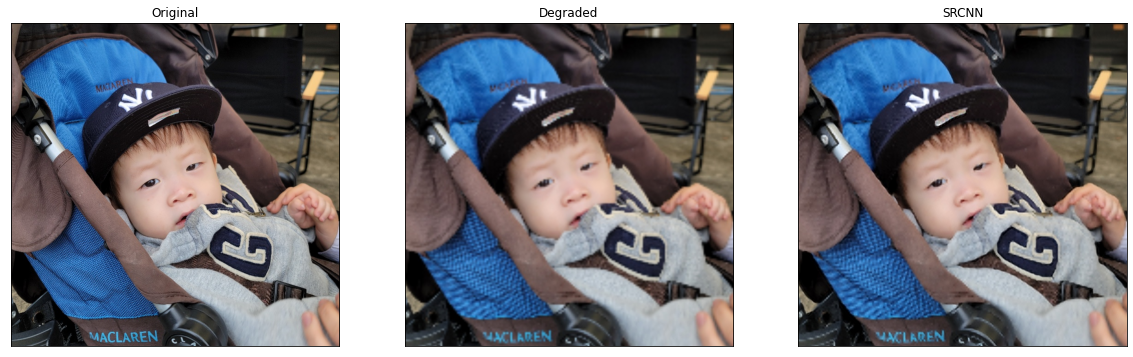

In [89]:
ref, degraded, output, scores = predict('downgraded_baby.jpg')

# print all scores for all images
print('Degraded Image : \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image : \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))

# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20,8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title("Original")
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title("Degraded")
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title("SRCNN")

# remove the x and y tick marks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])